In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

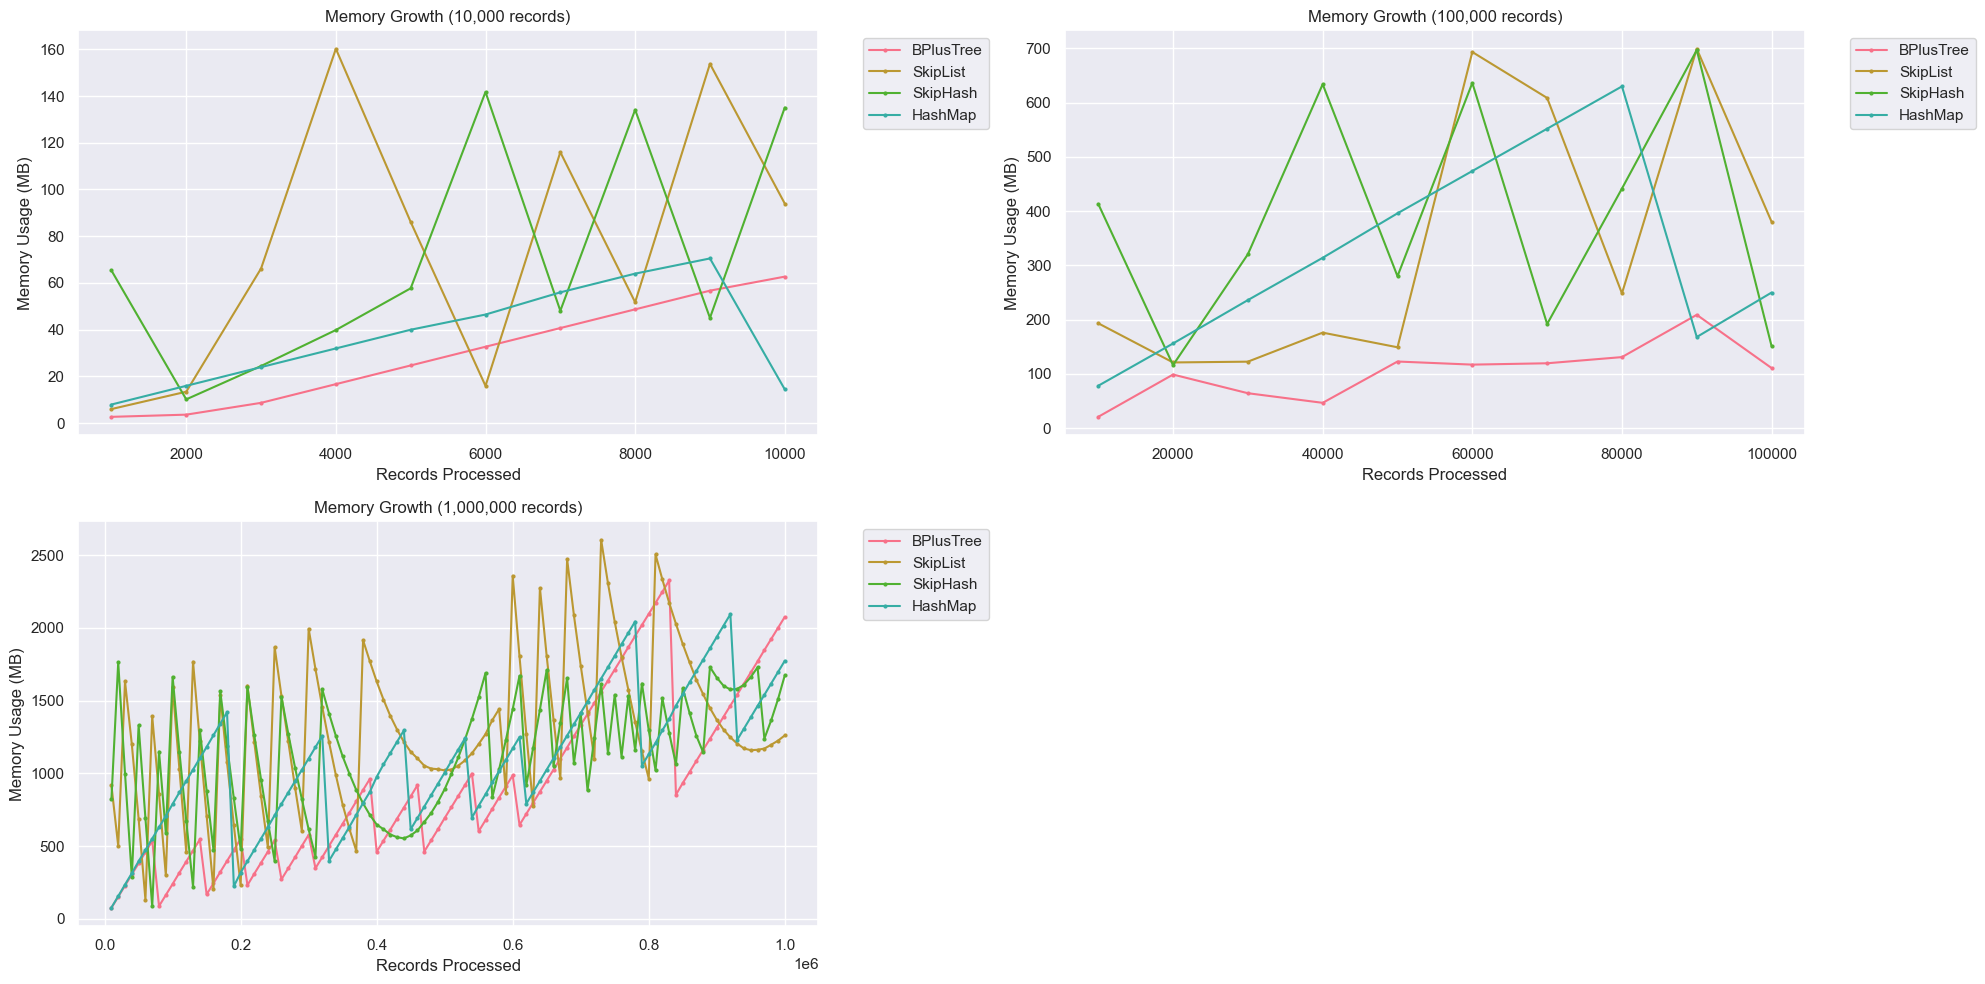

In [30]:
# Read the CSV files
detailed_df = pd.read_csv('results/memory_measurements_detailed.csv')
summary_df = pd.read_csv('results/memory_measurements_summary.csv')

# Set style
plt.style.use('default')
sns.set_theme(style="darkgrid")
sns.set_palette("husl")

# 1. Memory Growth Over Time
plt.figure(figsize=(20, 10))
num_plots = len(detailed_df['DatasetSize'].unique())
num_cols = 2
num_rows = (num_plots + 1) // num_cols

for i, size in enumerate(sorted(detailed_df['DatasetSize'].unique()), 1):
    data = detailed_df[detailed_df['DatasetSize'] == size]
    plt.subplot(num_rows, num_cols, i)
    
    for impl in data['Implementation'].unique():
        impl_data = data[data['Implementation'] == impl]
        plt.plot(impl_data['RecordsProcessed'], impl_data['TotalMemoryMB'], 
                label=impl, marker='o', markersize=2)
    
    plt.title(f'Memory Growth ({size:,} records)')
    plt.xlabel('Records Processed')
    plt.ylabel('Memory Usage (MB)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

plt.tight_layout()
plt.savefig('memory_growth.png', bbox_inches='tight', dpi=300)
plt.show()

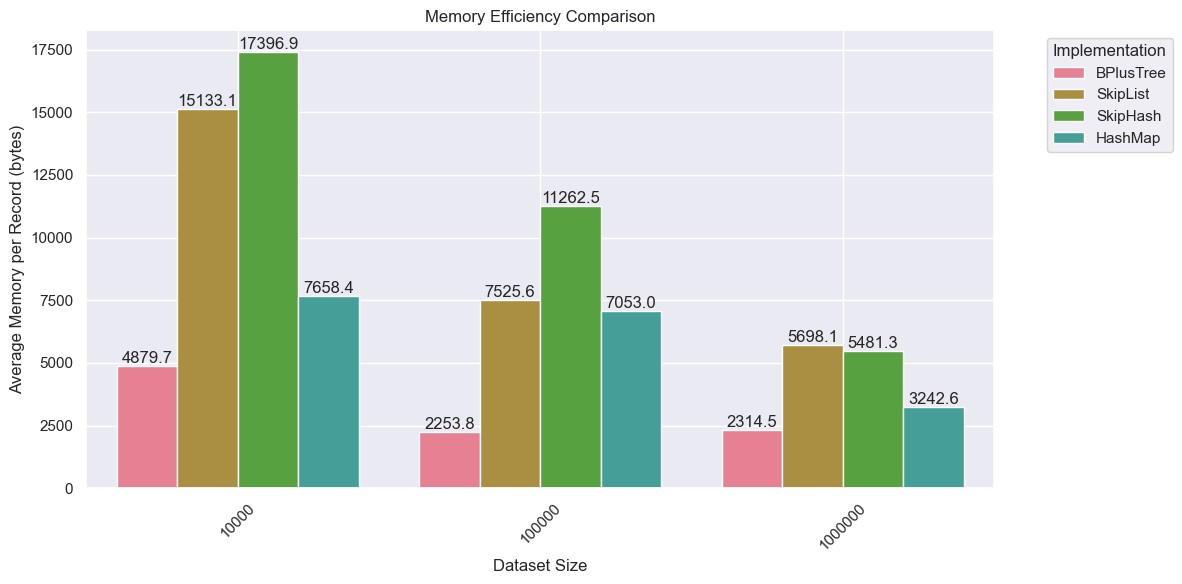

In [31]:
# 2. Memory Efficiency Comparison
plt.figure(figsize=(12, 6))
efficiency_plot = sns.barplot(data=summary_df, x='DatasetSize', y='AverageMemoryPerRecord', 
                            hue='Implementation')
plt.title('Memory Efficiency Comparison')
plt.xlabel('Dataset Size')
plt.ylabel('Average Memory per Record (bytes)')
plt.xticks(rotation=45)
plt.legend(title='Implementation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Add value labels on bars
for container in efficiency_plot.containers:
    efficiency_plot.bar_label(container, fmt='%.1f')

plt.tight_layout()
plt.savefig('memory_efficiency.png', bbox_inches='tight', dpi=300)
plt.show()

As dataset size increases from 10K to 1M records, the average memory per record decreases across all implementations, reflecting better amortization of fixed overhead.

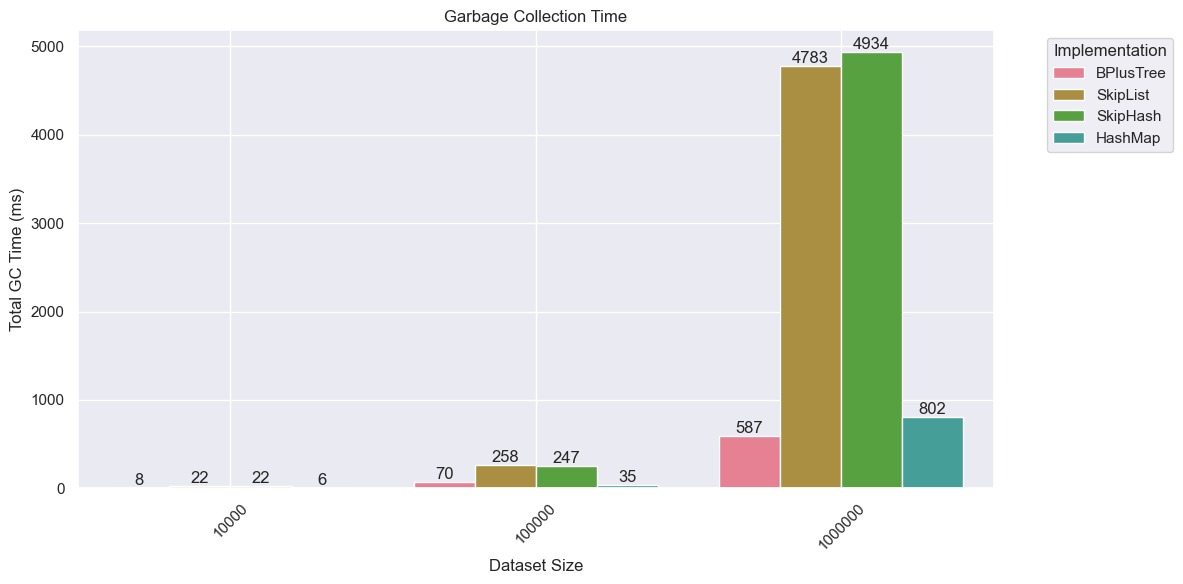

In [32]:
# 3. GC Activity
plt.figure(figsize=(12, 6))
gc_plot = sns.barplot(data=summary_df, x='DatasetSize', y='TotalGCTimeMs', 
                     hue='Implementation')
plt.title('Garbage Collection Time')
plt.xlabel('Dataset Size')
plt.ylabel('Total GC Time (ms)')
plt.xticks(rotation=45)
plt.legend(title='Implementation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Add value labels on bars
for container in gc_plot.containers:
    gc_plot.bar_label(container, fmt='%.0f')

plt.tight_layout()
plt.savefig('gc_activity.png', bbox_inches='tight', dpi=300)
plt.show()

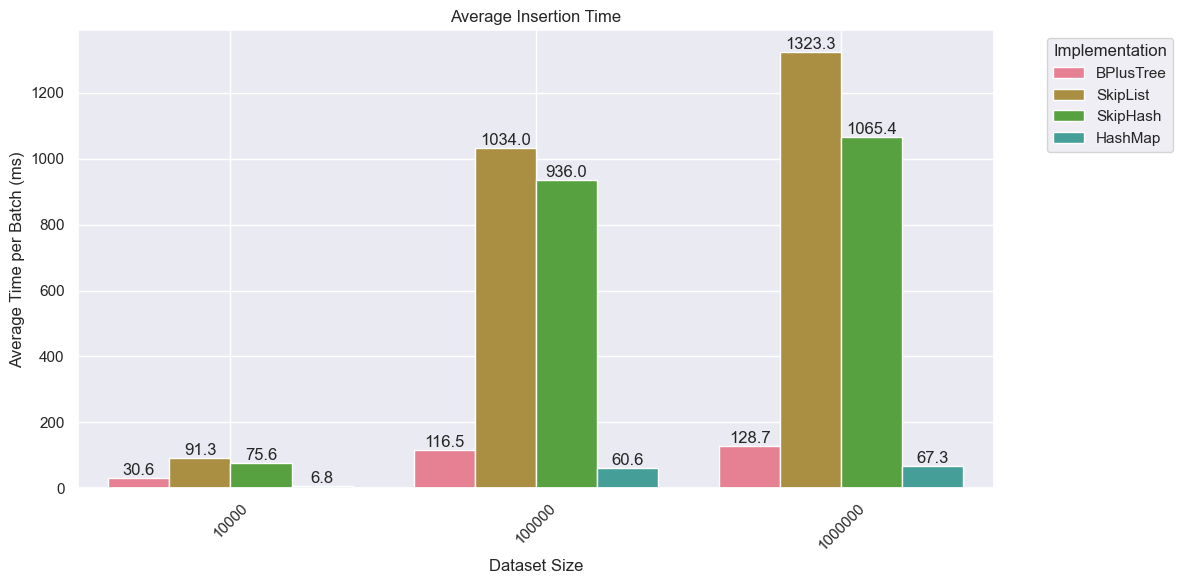

In [33]:
# 4. Insertion Performance
plt.figure(figsize=(12, 6))
insertion_plot = sns.barplot(data=summary_df, x='DatasetSize', y='AverageInsertionTimeMs', 
                           hue='Implementation')
plt.title('Average Insertion Time')
plt.xlabel('Dataset Size')
plt.ylabel('Average Time per Batch (ms)')
plt.xticks(rotation=45)
plt.legend(title='Implementation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Add value labels on bars
for container in insertion_plot.containers:
    insertion_plot.bar_label(container, fmt='%.1f')

plt.tight_layout()
plt.savefig('insertion_performance.png', bbox_inches='tight', dpi=300)
plt.show()

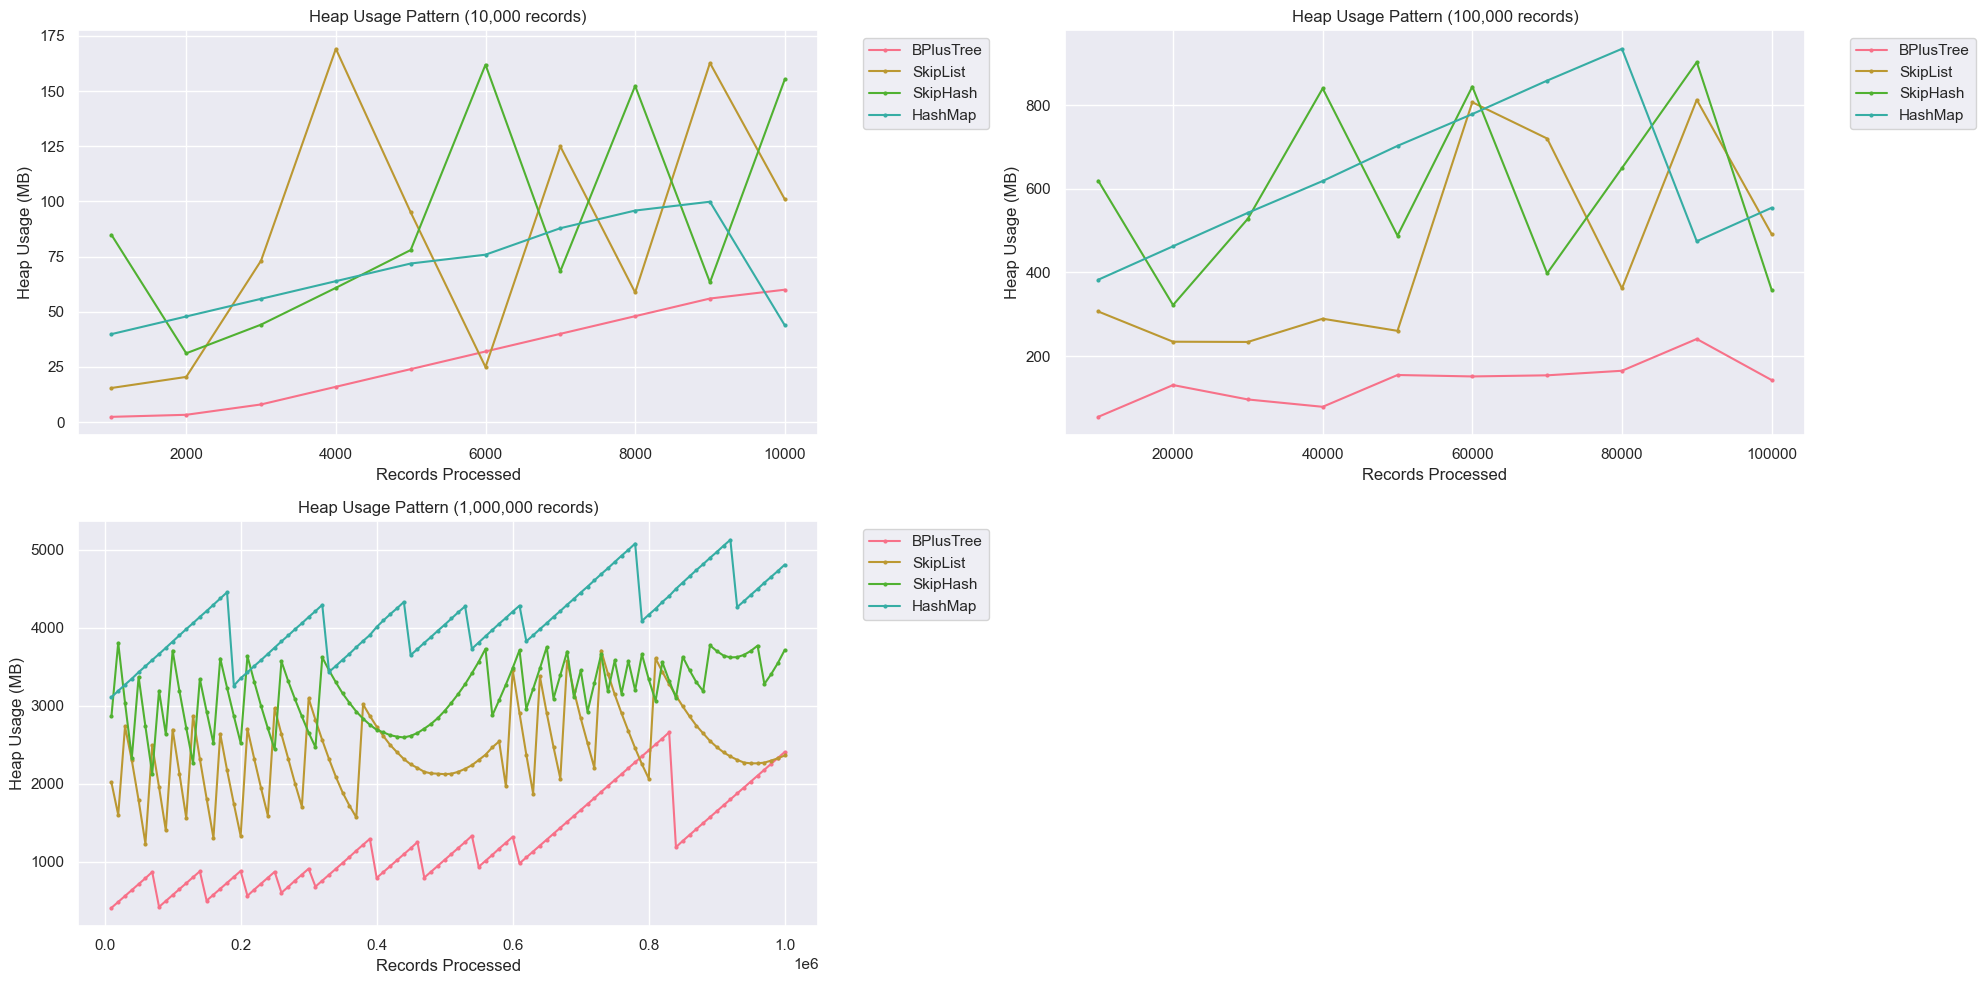

In [35]:
# 6. Heap Usage Pattern
plt.figure(figsize=(20, 10))
num_plots = len(detailed_df['DatasetSize'].unique())
num_cols = 2
num_rows = (num_plots + 1) // num_cols

for i, size in enumerate(sorted(detailed_df['DatasetSize'].unique()), 1):
    data = detailed_df[detailed_df['DatasetSize'] == size]
    plt.subplot(num_rows, num_cols, i)
    
    for impl in data['Implementation'].unique():
        impl_data = data[data['Implementation'] == impl]
        plt.plot(impl_data['RecordsProcessed'], impl_data['HeapUsageMB'], 
                label=impl, marker='o', markersize=2)
    
    plt.title(f'Heap Usage Pattern ({size:,} records)')
    plt.xlabel('Records Processed')
    plt.ylabel('Heap Usage (MB)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

plt.tight_layout()
plt.savefig('heap_usage.png', bbox_inches='tight', dpi=300)
plt.show()

In [36]:
# Print summary statistics
print("\nSummary Statistics:")
print("\n1. Average Memory per Record (bytes):")
print(summary_df.pivot_table(
    values='AverageMemoryPerRecord',
    index='Implementation',
    columns='DatasetSize',
    aggfunc='mean'
).round(2))

print("\n2. Total GC Time (ms):")
print(summary_df.pivot_table(
    values='TotalGCTimeMs',
    index='Implementation',
    columns='DatasetSize',
    aggfunc='sum'
).round(2))

print("\n3. Average Insertion Time (ms):")
print(summary_df.pivot_table(
    values='AverageInsertionTimeMs',
    index='Implementation',
    columns='DatasetSize',
    aggfunc='mean'
).round(2))

print("\n4. Final Memory Usage (MB):")
print(summary_df.pivot_table(
    values='FinalMemoryMB',
    index='Implementation',
    columns='DatasetSize',
    aggfunc='max'
).round(2))

# Calculate and print efficiency metrics
print("\nEfficiency Metrics:")
for impl in summary_df['Implementation'].unique():
    impl_data = summary_df[summary_df['Implementation'] == impl]
    print(f"\n{impl}:")
    
    # Memory scaling factor (how much memory usage increases as dataset size increases)
    memory_scaling = np.polyfit(impl_data['DatasetSize'], 
                              impl_data['FinalMemoryMB'], 1)[0]
    print(f"Memory Scaling Factor: {memory_scaling:.6f} MB/record")
    
    # GC pressure (GC time per record)
    gc_pressure = impl_data['TotalGCTimeMs'].sum() / impl_data['DatasetSize'].sum()
    print(f"GC Pressure: {gc_pressure:.6f} ms/record")
    
    # Average insertion throughput
    avg_throughput = impl_data['DatasetSize'].sum() / (impl_data['TotalInsertionTimeMs'].sum() / 1000)
    print(f"Average Throughput: {avg_throughput:.2f} records/second")


Summary Statistics:

1. Average Memory per Record (bytes):
DatasetSize      10000     100000   1000000
Implementation                             
BPlusTree        4879.74   2253.78  2314.54
HashMap          7658.35   7053.02  3242.59
SkipHash        17396.94  11262.47  5481.29
SkipList        15133.15   7525.59  5698.11

2. Total GC Time (ms):
DatasetSize     10000    100000   1000000
Implementation                           
BPlusTree             8       70      587
HashMap               6       35      802
SkipHash             22      247     4934
SkipList             22      258     4783

3. Average Insertion Time (ms):
DatasetSize     10000    100000   1000000
Implementation                           
BPlusTree          30.6    116.5   128.65
HashMap             6.8     60.6    67.35
SkipHash           75.6    936.0  1065.38
SkipList           91.3   1034.0  1323.28

4. Final Memory Usage (MB):
DatasetSize     10000    100000   1000000
Implementation                           
BP